The University of Melbourne, School of Computing and Information Systems

# COMP30027 Machine Learning, 2024 Semester 1
## Project 2: IMDB Movie Rating Prediction

The goal of this project is to build and critically analyze supervised machine learning methods for predicting IMDB movie ratings based on various predictor variables that include movie-title, duration, director and actor(s) names and facebook likes, keywords, genre, country, budget, and others. There are five possible outcomes 0 being the lowest and 4 being the highest.

This assignment aims to reinforce the largely theoretical lecture concepts surrounding data representation, classifier construction, evaluation and error analysis, by applying them to an open-ended problem. You will also have an opportunity to practice your general problem-solving skills, written communication skills, and critical thinking skills

# Imports


In [1]:
import pandas as pd
import numpy as np
from collections import Counter
from tqdm import tqdm

# stop words
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('english'))

# general
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, LabelEncoder, FunctionTransformer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score, classification_report
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif, chi2
from sklearn.inspection import permutation_importance
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import TruncatedSVD
from sklearn.utils import resample
from sklearn.ensemble import VotingClassifier
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from scipy.sparse import csr_matrix

# classifiers
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression, LogisticRegression

# visualisation
import seaborn as sns
from sklearn import tree
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jason\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jason\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Read data into Dataframes


In [49]:
# Read training and testing dataset into dataframes
train_df = pd.read_csv("project_data/train_dataset.csv")
test_df = pd.read_csv("project_data/test_dataset.csv")

original_columns = list(train_df.columns)
original_numerical = train_df.select_dtypes(include=['int', 'float']).columns

# Feature Engineering 

In [50]:

# Load the features from the .npy files
train_doc2vec_features_plot_keywords = np.load('project_data/features_doc2vec/train_doc2vec_features_plot_keywords.npy')
train_doc2vec_features_genre = np.load('project_data/features_doc2vec/train_doc2vec_features_genre.npy')

test_doc2vec_features_plot_keywords = np.load('project_data/features_doc2vec/test_doc2vec_features_plot_keywords.npy')
test_doc2vec_features_genre = np.load('project_data/features_doc2vec/test_doc2vec_features_genre.npy')

# Convert features to strings and assign them to DataFrame columns
# train_df['plot_keywords'] = [str(feature) for feature in train_doc2vec_features_plot_keywords]
# train_df['genres'] = [str(feature) for feature in train_doc2vec_features_genre]

# test_df['plot_keywords'] = [str(feature) for feature in test_doc2vec_features_plot_keywords]
# test_df['genres'] = [str(feature) for feature in test_doc2vec_features_genre]

# Convert genres to individual columns (OneHotEncoding)
genre_dummies = train_df['genres'].str.get_dummies(sep='|')
genre_dummies.drop(columns='Film-Noir', inplace=True)         # Only occurs once
train_df = pd.concat([train_df, genre_dummies], axis=1)
train_df.drop(columns='genres', inplace=True)

genre_dummies_test = test_df['genres'].str.get_dummies(sep='|')
test_df = pd.concat([test_df, genre_dummies_test], axis=1)
test_df.drop(columns='genres', inplace=True)

# Drop title_embeddings (not sure how to interpret FastText)
if 'title_embedding' in train_df.columns:
    train_df.drop(columns='title_embedding', inplace=True)

if 'title_embedding' in test_df.columns:
    test_df.drop(columns='title_embedding', inplace=True)

# Convert plot_keywords to individual columns (OneHotEncoding)
num_plots = 50
top_keywords = train_df['plot_keywords'].str.split('|', expand=True).stack().value_counts().head(num_plots).index

for keyword in top_keywords:
    # Train dataframe
    train_df[keyword] = train_df['plot_keywords'].apply(lambda x: 1 if keyword in x else 0)
    # Test dataframe
    test_df[keyword] = test_df['plot_keywords'].apply(lambda x: 1 if keyword in x else 0)

train_df.drop('plot_keywords', axis=1, inplace=True)
test_df.drop('plot_keywords', axis=1, inplace=True)

# Replace names that occur less than average with "Other
# Calculate average counts for director and actors 1, 2, and 3
director_counts = train_df['director_name'].value_counts()
actor1_counts = train_df['actor_1_name'].value_counts()
actor2_counts = train_df['actor_2_name'].value_counts()
actor3_counts = train_df['actor_3_name'].value_counts()

director_average_count = np.mean(director_counts)
actor1_average_count = np.mean(actor1_counts)
actor2_average_count = np.mean(actor2_counts)
actor3_average_count = np.mean(actor3_counts)

# Get rare entries
rare_directors = director_counts[director_counts < director_average_count].index
rare_actors1 = actor1_counts[actor1_counts < actor1_average_count].index
rare_actors2 = actor2_counts[actor2_counts < actor2_average_count].index
rare_actors3 = actor3_counts[actor3_counts < actor3_average_count].index

# Replace rare actors with 'Other'
train_df.loc[train_df['director_name'].isin(rare_directors), 'director_name'] = 'Other'
train_df.loc[train_df['actor_1_name'].isin(rare_actors1), 'actor_1_name'] = 'Other'
train_df.loc[train_df['actor_2_name'].isin(rare_actors2), 'actor_2_name'] = 'Other'
train_df.loc[train_df['actor_3_name'].isin(rare_actors3), 'actor_3_name'] = 'Other'

test_df.loc[test_df['director_name'].isin(rare_directors), 'director_name'] = 'Other'
test_df.loc[test_df['actor_1_name'].isin(rare_actors1), 'actor_1_name'] = 'Other'
test_df.loc[test_df['actor_2_name'].isin(rare_actors2), 'actor_2_name'] = 'Other'
test_df.loc[test_df['actor_3_name'].isin(rare_actors3), 'actor_3_name'] = 'Other'

def preprocess_title(title):
    if isinstance(title, str):  
        title = title.lower()
        words = word_tokenize(title)
        # Remove stop words
        stop_words = set(stopwords.words('english'))
        words = [word for word in words if word not in stop_words]
        words = [word for word in words if word not in string.punctuation]
        # Join the remaining words back into a string
        preprocessed_title = ' '.join(words)
        return preprocessed_title
    else:
        return ""

# preprocess movie titles
train_df['movie_title'] = train_df['movie_title'].apply(preprocess_title)
test_df['movie_title'] = test_df['movie_title'].apply(preprocess_title)

print(train_df.shape)
print(test_df.shape)
display(train_df.sample(3))

print(list(train_df.iloc[85]))
print(list(test_df.iloc[53]))
# print(list(train_df.iloc[575]))

(3004, 95)
(752, 94)


,id,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,actor_1_name,...,president,hospital,texas,teenager,train,scientist,writer,baby,student,fight
1005,1006,Other,152,83,26,801,Mark Duplass,10000,25799043,Olivia Wilde,...,0,0,0,0,0,0,0,0,0,0
1559,1560,Other,276,123,160,402,Matt Long,12000,115802596,Nicolas Cage,...,0,0,0,0,0,0,0,0,0,0
1824,1825,Woody Allen,128,108,11000,922,Stockard Channing,11000,3203044,Woody Allen,...,0,0,0,0,0,0,1,0,0,0


[86, 'Other', 161, 89, 7, 399, 'Daniella Alonso', 919, 20801344, 'Other', 'hills eyes ii', 49721, 2559, 'Jacob Vargas', 0, 211, 'English', 'USA', 'R', 2007, 557, 0, 0.000525289, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
[54, 'Chris Weitz', 61, 87, 129, 560, 'Mark Addy', 979, 64172251, 'Chazz Palminteri', 'earth', 19079, 2911, 'Other', 1, 122, 'English', 'USA', 'PG-13', 2001, 891, 602, 0.002101156, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [51]:
# Separate features and class for training df
train_df = train_df.dropna(how='any') # drop rows with any missing values

X = train_df.drop(columns=["imdb_score_binned"])         
y = train_df["imdb_score_binned"]

# Test dataset only contains features without labels 
X_test = test_df

print(X.shape, X_test.shape)

(3003, 94) (752, 94)


In [52]:
# Define features 
numeric_features = list(X.select_dtypes(include=['int64', 'float64', 'float32']).columns)
name_features = ['director_name', 'actor_2_name', 'actor_1_name', 'actor_3_name']
categorical_features = [col for col in X.select_dtypes(include=['object']).columns if col not in name_features]

print(numeric_features)
print(categorical_features)
print(name_features)

['id', 'num_critic_for_reviews', 'duration', 'director_facebook_likes', 'actor_3_facebook_likes', 'actor_1_facebook_likes', 'gross', 'num_voted_users', 'cast_total_facebook_likes', 'facenumber_in_poster', 'num_user_for_reviews', 'title_year', 'actor_2_facebook_likes', 'movie_facebook_likes', 'average_degree_centrality', 'Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'History', 'Horror', 'Music', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Sport', 'Thriller', 'War', 'Western', 'love', 'friend', 'murder', 'death', 'police', 'new york city', 'alien', 'high school', 'fbi', 'boy', 'school', 'prison', 'dog', 'drugs', 'money', 'escape', 'friendship', 'revenge', 'detective', 'wedding', 'party', 'hotel', 'island', 'christmas', 'female protagonist', 'cia', 'battle', 'marriage', 'rescue', 'college', 'box office flop', 'lawyer', 'secret', 'terrorist', 'best friend', 'serial killer', 'sex', 'spy', 'vampire', 'king', 'president', 'hos

# Explore Data

In [53]:
print('*'*60)
print("Shape of dataset : ",X.shape)
print('*'*60)
print("NUMERICAL DATA ANALYSIS")
print('*'*60)
print(X.describe().T)
print('*'*60)
print("CATEGORICAL DATA ANALYSIS")
print('*'*60)
print(X.describe(exclude = ['float', 'int64']).T)
print('*'*60)
print("MISSING VALUES")
print('*'*60)
print(X.isnull().sum())
print('*'*60)

************************************************************
Shape of dataset :  (3003, 94)
************************************************************
NUMERICAL DATA ANALYSIS
************************************************************
                          count         mean          std   min    25%  \
id                       3003.0  1502.071928   867.151427   1.0  751.5   
num_critic_for_reviews   3003.0   165.626041   121.271224   2.0   76.0   
duration                 3003.0   110.079254    21.913761  37.0   96.0   
director_facebook_likes  3003.0   779.039627  2991.228806   0.0   10.0   
actor_3_facebook_likes   3003.0   768.115884  1902.256322   0.0  191.0   
...                         ...          ...          ...   ...    ...   
scientist                3003.0     0.010656     0.102694   0.0    0.0   
writer                   3003.0     0.011988     0.108850   0.0    0.0   
baby                     3003.0     0.011655     0.107345   0.0    0.0   
student               

# Visualise Data

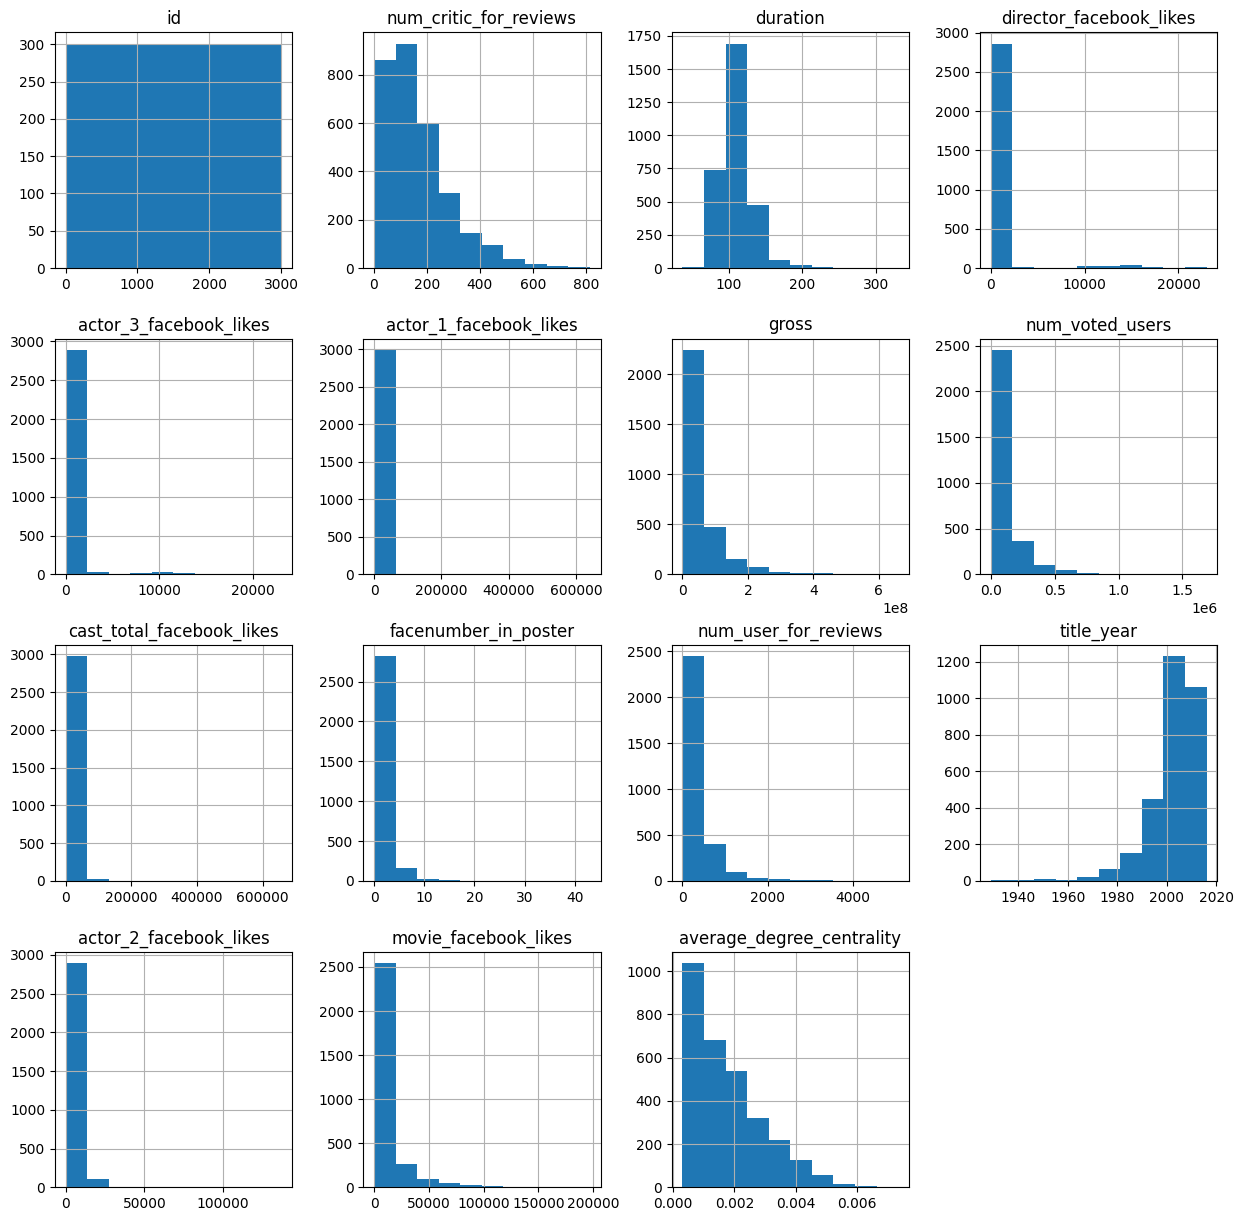

In [266]:
features = ["id", "num_critic_for_reviews", "duration", "director_facebook_likes", "actor_3_facebook_likes", "actor_1_facebook_likes", "gross", "num_voted_users", "cast_total_facebook_likes", "facenumber_in_poster", "num_user_for_reviews", "title_year", "actor_2_facebook_likes", "movie_facebook_likes", "average_degree_centrality"]

histograms = X[features].hist(figsize = [15, 15])
plt.savefig('histograms.png')

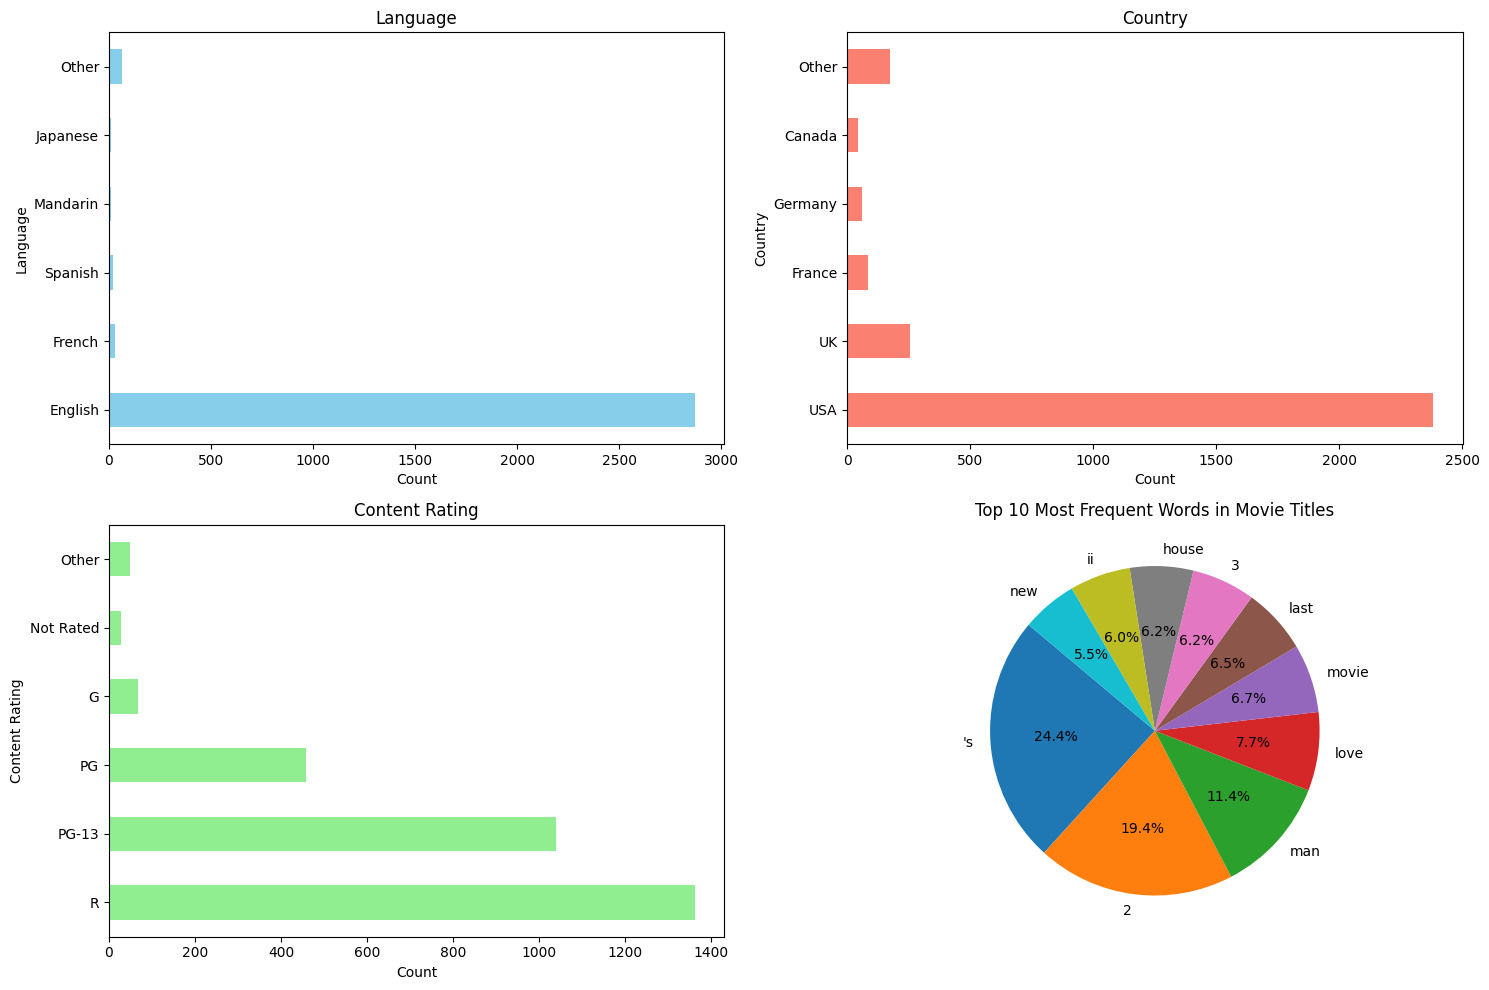

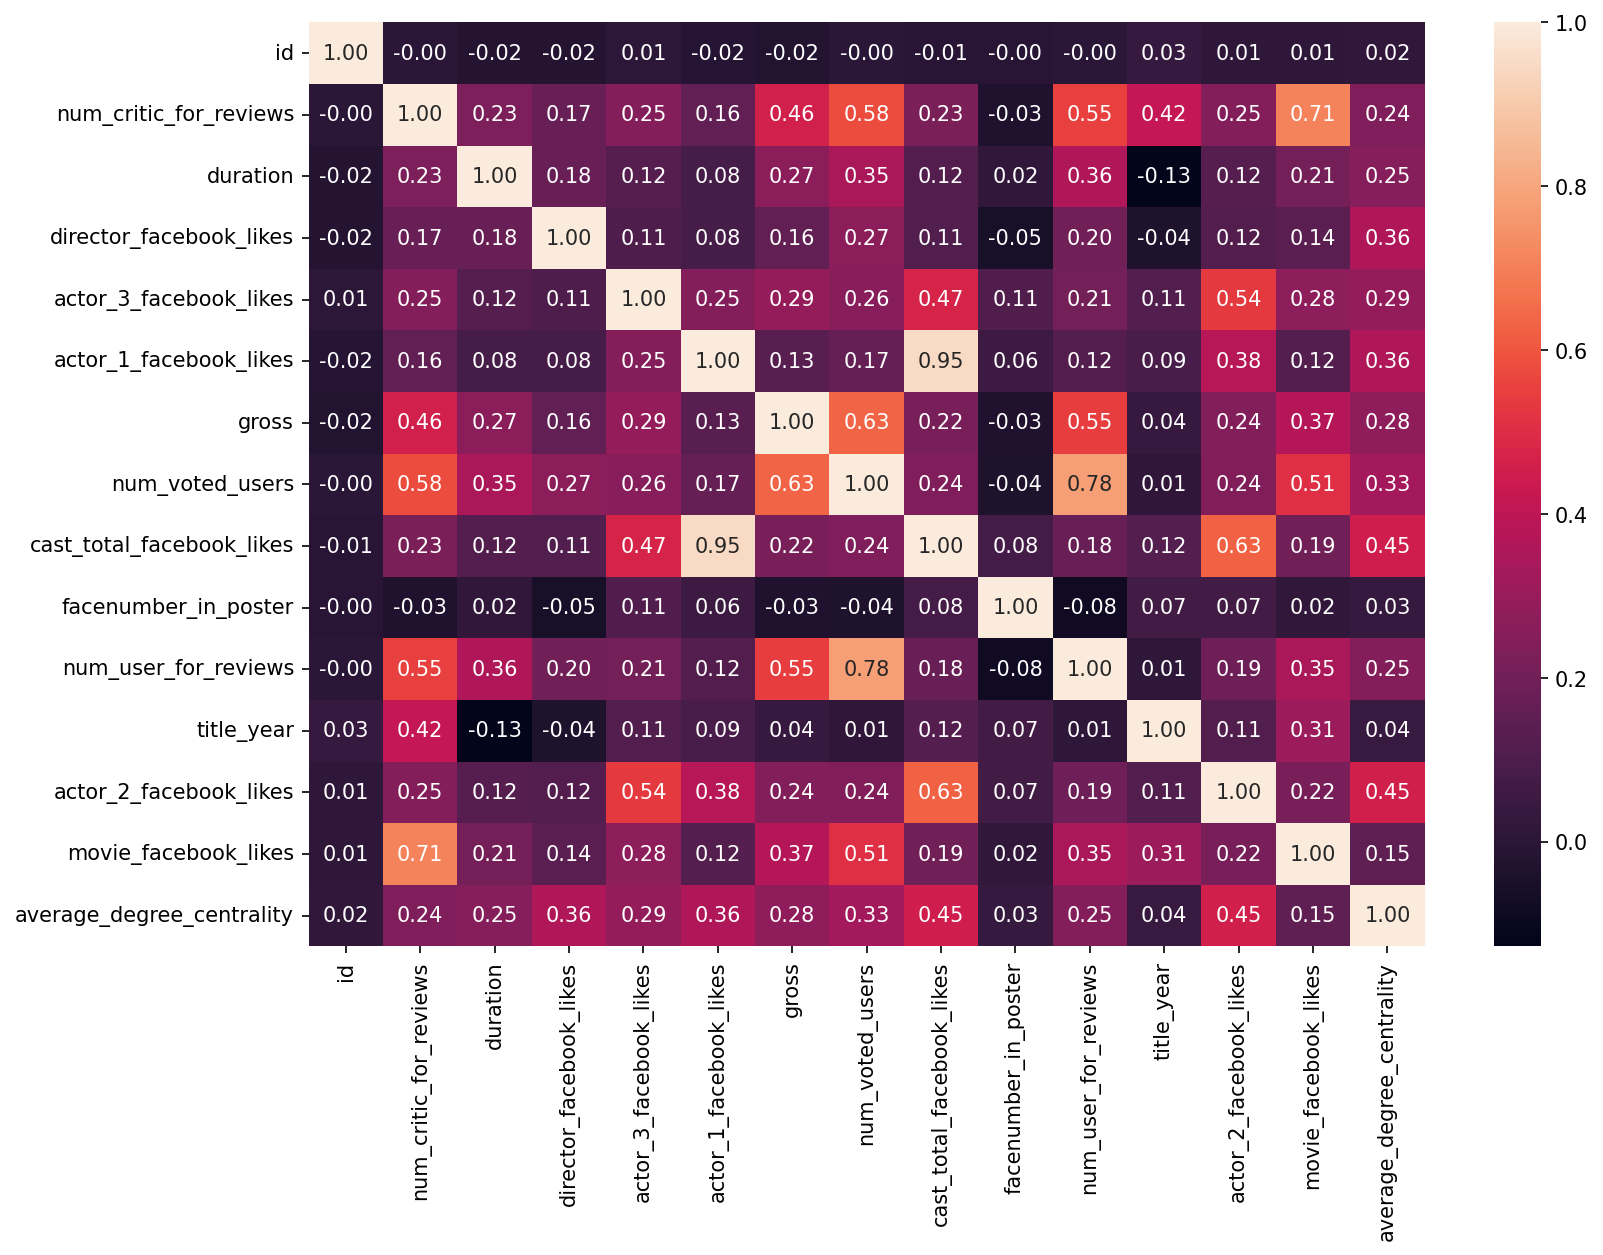

Top 10 Director Counts:


,Director,Count
0,Other,1369
1,Steven Spielberg,21
2,Woody Allen,15
3,Clint Eastwood,15
4,Steven Soderbergh,14
5,Tim Burton,14
6,Spike Lee,12
7,Robert Zemeckis,12
8,Michael Bay,11
9,Wes Craven,11



Top 10 Actor 1 Counts:


,Actor 1,Count
0,Other,1210
1,Johnny Depp,30
2,Robert De Niro,28
3,Harrison Ford,24
4,J.K. Simmons,23
5,Nicolas Cage,23
6,Denzel Washington,23
7,Robert Downey Jr.,22
8,Bruce Willis,22
9,Matt Damon,22



Top 10 Actor 2 Counts:


,Actor 2,Count
0,Other,1331
1,Morgan Freeman,15
2,Charlize Theron,12
3,Judy Greer,9
4,Scott Glenn,8
5,James Franco,8
6,Rosario Dawson,8
7,Will Ferrell,8
8,Thomas Kretschmann,8
9,Meryl Streep,7



Top 10 Actor 3 Counts:


,Actor 3,Count
0,Other,1668
1,Robert Duvall,7
2,Steve Coogan,7
3,Ben Mendelsohn,6
4,Jon Gries,5
5,Gary Oldman,5
6,Bruce McGill,5
7,Cedric the Entertainer,5
8,Craig T. Nelson,5
9,Desmond Llewelyn,5


<Figure size 640x480 with 0 Axes>

In [267]:
#Plotting the categorical variables on the target
plot_data = True

if plot_data:
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Plot horizontal bar plot for language
    language_counts = X['language'].value_counts()
    top_languages = language_counts[:5]  # Display only the top 5 languages
    other_languages_count = language_counts[5:].sum()
    top_languages['Other'] = other_languages_count
    top_languages.plot(kind='barh', ax=axes[0, 0], color='skyblue')
    axes[0, 0].set_title('Language')
    axes[0, 0].set_ylabel('Language')
    axes[0, 0].set_xlabel('Count')

    # Plot horizontal bar plot for country
    country_counts = X['country'].value_counts()
    top_countries = country_counts[:5]  # Display only the top 5 countries
    other_countries_count = country_counts[5:].sum()
    top_countries['Other'] = other_countries_count
    top_countries.plot(kind='barh', ax=axes[0, 1], color='salmon')
    axes[0, 1].set_title('Country')
    axes[0, 1].set_ylabel('Country')
    axes[0, 1].set_xlabel('Count')

    # Plot horizontal bar plot for content rating
    content_rating_counts = X['content_rating'].value_counts()
    top_content_ratings = content_rating_counts[:5]  # Display only the top 5 content ratings
    other_content_rating_count = content_rating_counts[5:].sum()
    top_content_ratings['Other'] = other_content_rating_count
    top_content_ratings.plot(kind='barh', ax=axes[1, 0], color='lightgreen')
    axes[1, 0].set_title('Content Rating')
    axes[1, 0].set_ylabel('Content Rating')
    axes[1, 0].set_xlabel('Count')

    # Plot for title words
    # Flatten the list of lists into a single list of words
    words = X['movie_title'].apply(lambda x: x.split())
    all_words = [word.lower() for title_words in words for word in title_words]
    filtered_unique_words = [word for word in all_words if word.lower() not in stop_words]

    # Count the occurrences of each word
    word_counts = Counter(filtered_unique_words)
    top_words = word_counts.most_common(10)

    # Plot the pie chart
    ax = axes[1, 1]
    ax.pie([count for word, count in top_words], labels=[word for word, count in top_words], autopct='%1.1f%%', startangle=140)
    ax.set_title('Top 10 Most Frequent Words in Movie Titles')

    plt.tight_layout()
    plt.show()

# Correlation HeatMap
plt.figure(figsize=(12,8), dpi=150)
sns.heatmap(X[original_numerical[:-1]].corr(), annot=True, fmt='.2f')

plt.show()
plt.savefig('correlation_heatmap.png')


# Display top 15 names
director_counts = X['director_name'].value_counts().head(15)
actor1_counts = X['actor_1_name'].value_counts().head(15)
actor2_counts = X['actor_2_name'].value_counts().head(15)
actor3_counts = X['actor_3_name'].value_counts().head(15)

director_counts_df = pd.DataFrame({'Director': director_counts.index, 'Count': director_counts.values})
actor1_counts_df = pd.DataFrame({'Actor 1': actor1_counts.index, 'Count': actor1_counts.values})
actor2_counts_df = pd.DataFrame({'Actor 2': actor2_counts.index, 'Count': actor2_counts.values})
actor3_counts_df = pd.DataFrame({'Actor 3': actor3_counts.index, 'Count': actor3_counts.values})

# Display DataFrames
print("Top 10 Director Counts:")
display(director_counts_df)

print("\nTop 10 Actor 1 Counts:")
display(actor1_counts_df)

print("\nTop 10 Actor 2 Counts:")
display(actor2_counts_df)

print("\nTop 10 Actor 3 Counts:")
display(actor3_counts_df)



# Doc2Vec

In [54]:
# Doc2Vec Encoder for categorical data -> numerical
class Doc2VecEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, vector_size=100, min_count=2, epochs=20):
        self.vector_size = vector_size
        self.min_count = min_count
        self.epochs = epochs
        self.model = None

    def fit(self, X, y=None):
        tagged_data = [TaggedDocument(words=doc.split(), tags=[str(i)]) for i, doc in enumerate(X)]
        self.model = Doc2Vec(vector_size=self.vector_size, min_count=self.min_count)
        self.model.build_vocab(tagged_data)
        self.model.train(tagged_data, total_examples=self.model.corpus_count, epochs=self.epochs)
        return self

    def transform(self, X):
        encoded_vectors = []
        for doc in X:
            vector = self.model.infer_vector(doc.split())
            encoded_vectors.append(vector)
        return encoded_vectors


In [11]:
# # Update all categorical features -> numeric (doc2vec)
# fitted_encoders = {}
# remaining_cat_features = ['language', 'country', 'content_rating']

# for feature in remaining_cat_features:
#     doc2vec_encoder = Doc2VecEncoder(vector_size=100, min_count=2, epochs=20)
#     encoded_categorical_features = doc2vec_encoder.fit_transform(X[feature])

#     X[feature] = [str(feature) for feature in encoded_categorical_features]

#     # Store the fitted encoder for later use
#     fitted_encoders[feature] = doc2vec_encoder


# # Transform Testing Data using the fitted encoders from the training data
# for feature in remaining_cat_features:
#     # Retrieve the fitted encoder for the current feature
#     doc2vec_encoder = fitted_encoders[feature]
    
#     # Transform the testing data using the fitted encoder
#     encoded_categorical_features_test = doc2vec_encoder.transform(X_test[feature])

#     X_test[feature] = [str(feature) for feature in encoded_categorical_features_test]


In [55]:
print(X.shape)
display(X.head(3))

print(list(X.iloc[0]))

(3003, 94)


,id,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,actor_1_name,...,president,hospital,texas,teenager,train,scientist,writer,baby,student,fight
0,1,Other,186,73,28,847,Nathan Lane,2000,422783777,Matthew Broderick,...,0,0,0,0,0,0,0,0,0,0
1,2,Other,252,97,0,233,Other,654,20433940,Other,...,0,0,0,0,0,0,0,0,0,0
2,3,David Gordon Green,232,117,234,221,Tye Sheridan,12000,371897,Nicolas Cage,...,0,0,0,0,0,0,0,0,0,0


[1, 'Other', 186, 73, 28, 847, 'Nathan Lane', 2000, 422783777, 'Matthew Broderick', 'lion king', 644348, 6458, 'Other', 0, 656, 'English', 'USA', 'G', 1994, 886, 17000, 0.001575867, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


## Feature Selection (after visualised data)

In [56]:
# drop features with high correlation with others "actor_1_facebook_likes"
# drop features with low variation
#   id, language, ...
# drop all categorical features (successfully vectorised to numerical)
dropped_features = ["id", "actor_1_facebook_likes"] 
                    # 'movie_title', 
                    # 'language', 
                    # 'country', 
                    # 'actor_1_facebook_likes', 
                    # 'actor_2_facebook_likes',
                    # 'actor_3_facebook_likes',
                    # 'num_user_for_reviews'] 

X.drop(columns=dropped_features, inplace=True)   
X_test.drop(columns=dropped_features, inplace = True)              

In [57]:
# Update features 
numeric_features = list(X.select_dtypes(include=['int64', 'float64', 'float32']).columns)
categorical_features = X.select_dtypes(include=['object']).columns
name_features = ['director_name', 'actor_2_name', 'actor_1_name', 'actor_3_name']

categorical_features = [col for col in categorical_features if col not in name_features]

print(numeric_features)
print(categorical_features)
print(name_features)


['num_critic_for_reviews', 'duration', 'director_facebook_likes', 'actor_3_facebook_likes', 'gross', 'num_voted_users', 'cast_total_facebook_likes', 'facenumber_in_poster', 'num_user_for_reviews', 'title_year', 'actor_2_facebook_likes', 'movie_facebook_likes', 'average_degree_centrality', 'Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'History', 'Horror', 'Music', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Sport', 'Thriller', 'War', 'Western', 'love', 'friend', 'murder', 'death', 'police', 'new york city', 'alien', 'high school', 'fbi', 'boy', 'school', 'prison', 'dog', 'drugs', 'money', 'escape', 'friendship', 'revenge', 'detective', 'wedding', 'party', 'hotel', 'island', 'christmas', 'female protagonist', 'cia', 'battle', 'marriage', 'rescue', 'college', 'box office flop', 'lawyer', 'secret', 'terrorist', 'best friend', 'serial killer', 'sex', 'spy', 'vampire', 'king', 'president', 'hospital', 'texas', 'teenager', 'tr

# Data Preprocessor

In [58]:
# Preprocessing for numerical data
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')), 
    ('scaler', MinMaxScaler())
])

# Preprocess for movie titles using TfIdf
movie_title_transformer = Pipeline(steps=[
    ('vectorizer', TfidfVectorizer()),
])

# Preprocessor for categorical strings (embedded vectors)
class StringToFloatTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return csr_matrix(X.apply(lambda x: [float(value) for value in x.strip('[]').split()]).values.tolist())

embedding_transformer = Pipeline(steps=[
    ('string_to_float', StringToFloatTransformer()),
])
# Transformers for name features
name_transformers = []
for feature in name_features:
    if feature in X.columns:
        name_transformer = Pipeline(steps=[
            # ('vectorizer', OneHotEncoder(handle_unknown="ignore")),
            ('vectorizer', TfidfVectorizer())
        ])
        # name_transformers.append((feature, name_transformer, [feature]))
        name_transformers.append((feature, name_transformer, feature))

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        # ('genre', embedding_transformer, 'genres'),  
        # ('plot', embedding_transformer, 'plot_keywords'),  
        # ('title', embedding_transformer, 'title_embedding'),  
        ('title', TfidfVectorizer(), 'movie_title'),
        ('language', OneHotEncoder(handle_unknown='ignore'), ['language']),  
        ('country', OneHotEncoder(handle_unknown='ignore'), ['country']),  
        ('content', OneHotEncoder(handle_unknown='ignore'), ['content_rating']),  
        *name_transformers
    ])

print(X.shape, X_test.shape)
# print(list(OneHotEncoder().fit_transform(X[['director_name']])[:3].toarray()))

X_processed = preprocessor.fit_transform(X)
print("Shape of processed data:", X_processed.shape)
print(list(X_processed[0].toarray()[0]))

(3003, 92) (752, 92)
Shape of processed data: (3003, 6142)
[0.22688039457459927, 0.12286689419795224, 0.0012173913043478262, 0.036826086956521745, 0.6418726242163515, 0.3812909361752244, 0.009833569351179329, 0.0, 0.12895569620253164, 0.7471264367816097, 0.0064671532846715335, 0.08629441624365482, 0.18085110605794258, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 

# Train-Test Split

In [59]:
# Split the training data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1)
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3)
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.01)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(2702, 92) (2702,)
(301, 92) (301,)


## Distribution of Movie Ratings


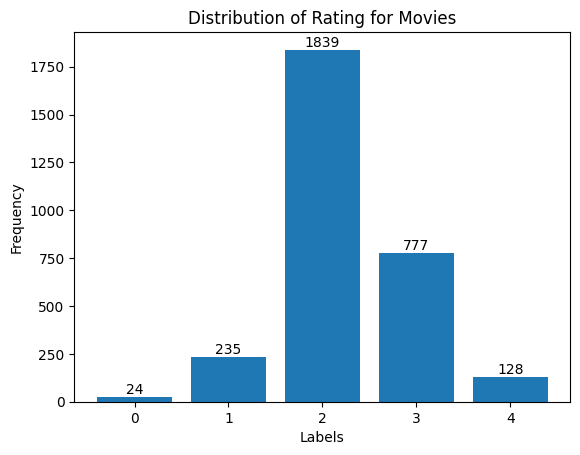

In [60]:
# Plot bar plot of y
counts = np.bincount(y)
plt.bar(range(len(counts)), counts)
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.title('Distribution of Rating for Movies')

# Annotate each bar with its count
for i, count in enumerate(counts):
    plt.text(i, count, str(count), ha='center', va='bottom')

plt.show()

## Min, Max, Average, Variance

In [129]:
print("Minimum of Ratings:", round(min(y),2))
print("Maximum of Ratings:", round(max(y),2))
print("Average of Ratings:", round(np.mean(y),2))
print("Variance of Ratings:",round(np.var(y),2))

Minimum of Ratings: 0
Maximum of Ratings: 4
Average of Ratings: 2.25
Variance of Ratings: 0.48


## Pair Plot

In [ ]:
# Create a pairplot
pairplot = sns.pairplot(X_train, hue='imdb_score', diag_kind='kde')

# save image
pairplot.savefig('pairplot.png')

## K-NN 

In [61]:
# Feature selection 
feature_selection = SelectKBest(score_func=f_classif, k=10)

# Define the pipeline with preprocessing, feature selection, and KNN classifier
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('feature_selection', feature_selection),
    ('knn', KNeighborsClassifier(weights='distance', metric='manhattan'))
])

# Define parameter grid
param_grid = {
    'knn__n_neighbors': range(30,35)
}

# Perform grid search with cross-validation
knn_grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', verbose=2)
knn_grid_search.fit(X_train, y_train)


Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] END ................................knn__n_neighbors=30; total time=   0.0s
[CV] END ................................knn__n_neighbors=30; total time=   0.0s
[CV] END ................................knn__n_neighbors=30; total time=   0.0s
[CV] END ................................knn__n_neighbors=30; total time=   0.0s
[CV] END ................................knn__n_neighbors=30; total time=   0.0s
[CV] END ................................knn__n_neighbors=31; total time=   0.0s
[CV] END ................................knn__n_neighbors=31; total time=   0.0s
[CV] END ................................knn__n_neighbors=31; total time=   0.0s
[CV] END ................................knn__n_neighbors=31; total time=   0.0s
[CV] END ................................knn__n_neighbors=31; total time=   0.0s
[CV] END ................................knn__n_neighbors=32; total time=   0.0s
[CV] END ................................knn__n_n

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          MinMaxScaler())]),
                                                                         ['num_critic_for_reviews',
                                                                          'duration',
                                                                          'director_facebook_likes',
                                                                          'actor_3_facebook_likes',
                                                                          'gross',
                                                                          'num_voted_users',
                                                                          'cast_total_facebook_likes',
                                                                          'facenumber_in_poster',
                                                                          'num_user_for_...
                                                                         'actor_2_name'),
                                                                        ('actor_1_name',
                                                                         Pipeline(steps=[('vectorizer',
                                                                                          TfidfVectorizer())]),
                                                                         'actor_1_name'),
                                                                        ('actor_3_name',
                                                                         Pipeline(steps=[('vectorizer',
                                                                                          TfidfVectorizer())]),
                                                                         'actor_3_name')])),
                                       ('feature_selection', SelectKBest()),
                                       ('knn',
                                        KNeighborsClassifier(metric='manhattan',
                                                             weights='distance'))]),
             param_grid={'knn__n_neighbors': range(30, 35)}, scoring='accuracy',
             verbose=2)

In [62]:
# Get the best parameters and best score
best_params = knn_grid_search.best_params_
best_score = knn_grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)

# Evaluate on the validation set using the best model
knn_best_model = knn_grid_search.best_estimator_

# View accuracy
val_accuracy = accuracy_score(y_val, knn_best_model.predict(X_val))
print("Validation Accuracy with Best Model:", val_accuracy)

Best Parameters: {'knn__n_neighbors': 30}
Best Score: 0.689114807968782
Validation Accuracy with Best Model: 0.6910299003322259


### Predict with KNN

In [63]:
# Make predictions on X_test with KNN
predictions = knn_best_model.predict(X_test)

# Create a DataFrame to store the predictions
prediction_df = pd.DataFrame({'id': range(1, len(predictions) + 1), 'imdb_score_binned': predictions})

# Write the predictions to a CSV file
prediction_df.to_csv('knn_predictions.csv', index=False)

## Decision Tree / Random Forest


In [66]:
# Define preprocessing steps
feature_selector = SelectKBest(score_func=f_classif, k=10)  
classifier = RandomForestClassifier(n_estimators=100, 
                                    max_features='sqrt',
                                    bootstrap=True,
                                    class_weight='balanced',
                                    max_depth=None)

# Define the pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    # ('feature_selector', feature_selector),
    ('classifier', classifier)
])

# Define parameter grid
param_grid = {
    'classifier__min_samples_split': [2, 5],
}

# Perform grid search with cross-validation
rf_grid_search = GridSearchCV(pipeline, param_grid, cv=10, scoring='accuracy', verbose=2)
rf_grid_search.fit(X_train, y_train)


Fitting 10 folds for each of 2 candidates, totalling 20 fits
[CV] END ....................classifier__min_samples_split=2; total time=   2.4s
[CV] END ....................classifier__min_samples_split=2; total time=   2.3s
[CV] END ....................classifier__min_samples_split=2; total time=   2.4s
[CV] END ....................classifier__min_samples_split=2; total time=   2.4s
[CV] END ....................classifier__min_samples_split=2; total time=   2.4s
[CV] END ....................classifier__min_samples_split=2; total time=   2.3s
[CV] END ....................classifier__min_samples_split=2; total time=   2.3s
[CV] END ....................classifier__min_samples_split=2; total time=   2.3s
[CV] END ....................classifier__min_samples_split=2; total time=   2.3s
[CV] END ....................classifier__min_samples_split=2; total time=   2.3s
[CV] END ....................classifier__min_samples_split=5; total time=   1.5s
[CV] END ....................classifier__min_sam

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          MinMaxScaler())]),
                                                                         ['num_critic_for_reviews',
                                                                          'duration',
                                                                          'director_facebook_likes',
                                                                          'actor_3_facebook_likes',
                                                                          'gross',
                                                                          'num_voted_users',
                                                                          'cast_total_facebook_likes',
                                                                          'facenumber_in_poster',
                                                                          'num_user_for...
                                                                                          TfidfVectorizer())]),
                                                                         'actor_2_name'),
                                                                        ('actor_1_name',
                                                                         Pipeline(steps=[('vectorizer',
                                                                                          TfidfVectorizer())]),
                                                                         'actor_1_name'),
                                                                        ('actor_3_name',
                                                                         Pipeline(steps=[('vectorizer',
                                                                                          TfidfVectorizer())]),
                                                                         'actor_3_name')])),
                                       ('classifier',
                                        RandomForestClassifier(class_weight='balanced'))]),
             param_grid={'classifier__min_samples_split': [2, 5]},
             scoring='accuracy', verbose=2)

In [67]:
# Get the best parameters and best score
best_params = rf_grid_search.best_params_
best_score = rf_grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)

# Evaluate on the validation set using the best model
rf_best_model = rf_grid_search.best_estimator_
val_accuracy = rf_best_model.score(X_val, y_val)
print("Validation Accuracy with Best Model:", val_accuracy)

Best Parameters: {'classifier__min_samples_split': 5}
Best Score: 0.7113297799644662
Validation Accuracy with Best Model: 0.7209302325581395


## Predict with Random Forest

In [68]:
# Make predictions on X_test with Random Forest
predictions = rf_best_model.predict(X_test)

# Create a DataFrame to store the predictions
prediction_df = pd.DataFrame({'id': range(1, len(predictions) + 1), 'imdb_score_binned': predictions})

# Write the predictions to a CSV file
prediction_df.to_csv('rf_predictions.csv', index=False)

## SVM


In [35]:
# Define feature selection, imputation, and SVM classifier
feature_selector = SelectKBest(score_func=f_classif, k="all")  
classifier = SVC(gamma='scale')

# Define the pipeline including feature engineering
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('feature_selector', feature_selector),
    ('classifier', classifier)
])

# Define parameter grid
param_grid = {
    'classifier__C': range(3,5)
}

# Perform grid search with cross-validation
svm_grid_search = GridSearchCV(pipeline, param_grid, cv=10, scoring='accuracy', verbose=2)   # Verbose shows comments during search
svm_grid_search.fit(X_train, y_train)


Fitting 10 folds for each of 2 candidates, totalling 20 fits
[CV] END ....................................classifier__C=3; total time=   1.4s
[CV] END ....................................classifier__C=3; total time=   1.5s
[CV] END ....................................classifier__C=3; total time=   1.4s
[CV] END ....................................classifier__C=3; total time=   1.4s
[CV] END ....................................classifier__C=3; total time=   1.4s
[CV] END ....................................classifier__C=3; total time=   1.4s
[CV] END ....................................classifier__C=3; total time=   1.3s
[CV] END ....................................classifier__C=3; total time=   1.4s
[CV] END ....................................classifier__C=3; total time=   1.4s
[CV] END ....................................classifier__C=3; total time=   1.4s
[CV] END ....................................classifier__C=4; total time=   1.4s
[CV] END ....................................cla

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          MinMaxScaler())]),
                                                                         ['num_critic_for_reviews',
                                                                          'duration',
                                                                          'director_facebook_likes',
                                                                          'actor_3_facebook_likes',
                                                                          'actor_1_facebook_likes',
                                                                          'gross',
                                                                          'num_voted_users',
                                                                          'cast_total_facebook_likes',
                                                                          'facenumber...
                                                                         Pipeline(steps=[('vectorizer',
                                                                                          TfidfVectorizer())]),
                                                                         'actor_2_name'),
                                                                        ('actor_1_name',
                                                                         Pipeline(steps=[('vectorizer',
                                                                                          TfidfVectorizer())]),
                                                                         'actor_1_name'),
                                                                        ('actor_3_name',
                                                                         Pipeline(steps=[('vectorizer',
                                                                                          TfidfVectorizer())]),
                                                                         'actor_3_name')])),
                                       ('feature_selector',
                                        SelectKBest(k='all')),
                                       ('classifier', SVC())]),
             param_grid={'classifier__C': range(3, 5)}, scoring='accuracy',
             verbose=2)

In [36]:
# Get the best parameters and best score
best_params = svm_grid_search.best_params_
best_score = svm_grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)

# Evaluate on the validation set using the best model
svm_best_model = svm_grid_search.best_estimator_
val_accuracy = svm_best_model.score(X_val, y_val)
print("Validation Accuracy with Best Model:", val_accuracy)
print("Classification Report:", classification_report(y_val, svm_best_model.predict(X_val), zero_division=1))


Best Parameters: {'classifier__C': 3}
Best Score: 0.7046685800191336
Validation Accuracy with Best Model: 0.7209302325581395
Classification Report:               precision    recall  f1-score   support

           0       1.00      0.00      0.00         5
           1       0.25      0.04      0.07        23
           2       0.74      0.90      0.81       192
           3       0.65      0.56      0.60        73
           4       1.00      0.38      0.55         8

    accuracy                           0.72       301
   macro avg       0.73      0.38      0.41       301
weighted avg       0.70      0.72      0.69       301



### Predict with SVM

In [37]:
# Make predictions on X_test with SVM
predictions = svm_best_model.predict(X_test)

# Create a DataFrame to store the predictions
prediction_df = pd.DataFrame({'id': range(1, len(predictions) + 1), 'imdb_score_binned': predictions})

# Write the predictions to a CSV file
prediction_df.to_csv('svm_predictions.csv', index=False)

## SVM Bagging

In [38]:
# BOOTSTRAPPING
# Define the number of bootstrap iterations
n_bootstrap = 50

# Initialize a list to store predictions
bagged_predictions = []

# Perform bootstrap resampling and bagging
for _ in tqdm(range(n_bootstrap), desc='Bootstrapping'):
    # Generate a bootstrap sample (with replacement)
    bootstrap_indices = np.random.choice(len(X_train), size=len(X_train), replace=True)
    X_bootstrap = X_train.iloc[bootstrap_indices]
    y_bootstrap = y_train.iloc[bootstrap_indices]

    # Fit on the bootstrap sample
    svm_grid_search.best_estimator_.fit(X_bootstrap, y_bootstrap)
    
    # Make predictions on X_test with the fitted SVM classifier
    predictions = svm_grid_search.best_estimator_.predict(X_test)
    bagged_predictions.append(predictions)

# Aggregate predictions using majority voting
voting_predictions = []
for i in range(len(X_test)):
    predictions = [bagged_pred[i] for bagged_pred in bagged_predictions]
    majority_prediction = max(set(predictions), key=predictions.count)
    voting_predictions.append(majority_prediction)


Bootstrapping: 100%|██████████| 50/50 [01:12<00:00,  1.44s/it]


In [39]:
# Output predictions to a CSV file
output_df = pd.DataFrame({'id': range(1, len(voting_predictions) + 1), 'imdb_score_binned': voting_predictions})
output_df.to_csv('svm-bagging_predictions.csv', index=False)

## Permutation Feature Importance

In [40]:
# Fit your SVM model (best_model) on the training data
svm_best_model.fit(X_train, y_train)

# Compute baseline performance on the validation set
baseline_score = svm_best_model.score(X_val, y_val)

# Compute permutation feature importance
perm_importance = permutation_importance(svm_best_model, X_val, y_val, n_repeats=10, random_state=42)

# Get feature importances and their names
feature_importances = perm_importance.importances_mean
feature_names = X_val.columns


[('num_voted_users', 0.019601328903654437),
 ('title_year', 0.01760797342192686),
 ('Horror', 0.016611295681063076),
 ('Action', 0.013953488372092971),
 ('num_user_for_reviews', 0.011960132890365394),
 ('language', 0.011627906976744129),
 ('Drama', 0.009966777408637818),
 ('movie_title', 0.007973421926910251),
 ('actor_2_name', 0.0069767441860464794),
 ('Family', 0.006976744186046468),
 ('Comedy', 0.006976744186046458),
 ('movie_facebook_likes', 0.006644518272425193),
 ('Documentary', 0.006644518272425193),
 ('gross', 0.005980066445182675),
 ('num_critic_for_reviews', 0.0049833887043188915),
 ('Crime', 0.00498338870431887),
 ('sex', 0.004651162790697594),
 ('actor_1_name', 0.004318936877076374),
 ('new york city', 0.00431893687707634),
 ('money', 0.0036544850498338),
 ('content_rating', 0.003322259136212591),
 ('fbi', 0.0033222591362125574),
 ('secret', 0.0033222591362125353),
 ('actor_3_name', 0.002990033222591304),
 ('Music', 0.0026578073089700725),
 ('alien', 0.0023255813953487747),

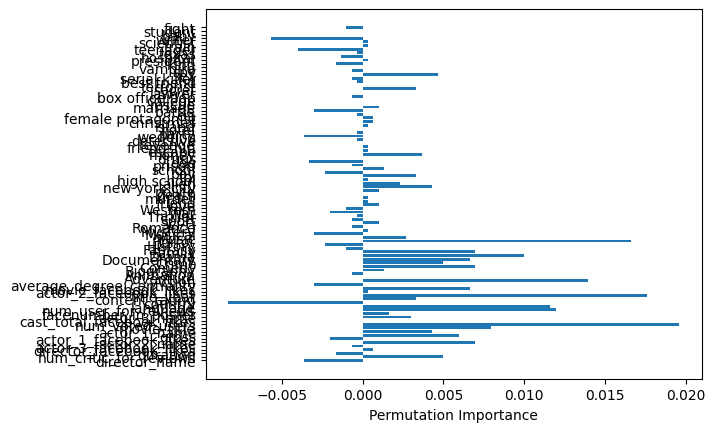

In [42]:

features = zip(feature_names, feature_importances)
sorted_features = sorted(features, key=lambda x: x[1], reverse=True)

display(sorted_features)

# Plot feature importance
plt.barh(feature_names, feature_importances)
plt.xlabel('Permutation Importance')
plt.show()


## Logistic Regression


In [43]:
# Define feature selection and logistic regression classifier
feature_selector = SelectKBest(score_func=f_classif, k=10)
classifier = LogisticRegression(max_iter=1000)  

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('feature_selector', feature_selector),
    ('classifier', classifier)
])

# Define parameter grid
param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10, 100] 
}

# Perform grid search with cross-validation
logistic_grid_search = GridSearchCV(pipeline, param_grid, cv=10, scoring='accuracy', verbose=2)
logistic_grid_search.fit(X_train, y_train)

Fitting 10 folds for each of 5 candidates, totalling 50 fits
[CV] END .................................classifier__C=0.01; total time=   0.1s
[CV] END .................................classifier__C=0.01; total time=   0.0s
[CV] END .................................classifier__C=0.01; total time=   0.0s
[CV] END .................................classifier__C=0.01; total time=   0.0s
[CV] END .................................classifier__C=0.01; total time=   0.0s
[CV] END .................................classifier__C=0.01; total time=   0.0s
[CV] END .................................classifier__C=0.01; total time=   0.0s
[CV] END .................................classifier__C=0.01; total time=   0.0s
[CV] END .................................classifier__C=0.01; total time=   0.0s
[CV] END .................................classifier__C=0.01; total time=   0.0s
[CV] END ..................................classifier__C=0.1; total time=   0.0s
[CV] END ..................................class

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          MinMaxScaler())]),
                                                                         ['num_critic_for_reviews',
                                                                          'duration',
                                                                          'director_facebook_likes',
                                                                          'actor_3_facebook_likes',
                                                                          'actor_1_facebook_likes',
                                                                          'gross',
                                                                          'num_voted_users',
                                                                          'cast_total_facebook_likes',
                                                                          'facenumber...
                                                                                          TfidfVectorizer())]),
                                                                         'actor_2_name'),
                                                                        ('actor_1_name',
                                                                         Pipeline(steps=[('vectorizer',
                                                                                          TfidfVectorizer())]),
                                                                         'actor_1_name'),
                                                                        ('actor_3_name',
                                                                         Pipeline(steps=[('vectorizer',
                                                                                          TfidfVectorizer())]),
                                                                         'actor_3_name')])),
                                       ('feature_selector', SelectKBest()),
                                       ('classifier',
                                        LogisticRegression(max_iter=1000))]),
             param_grid={'classifier__C': [0.01, 0.1, 1, 10, 100]},
             scoring='accuracy', verbose=2)

In [44]:
# Get the best model from the grid search
reg_best_model = logistic_grid_search.best_estimator_

# Predictions on validation set
y_pred_val = reg_best_model.predict(X_val)

# Calculate accuracy
accuracy = accuracy_score(y_val, y_pred_val)
print("Accuracy:", accuracy)

# Classification report
print("Classification Report:")
print(classification_report(y_val, y_pred_val, zero_division=1))

Accuracy: 0.7342192691029901
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       1.00      0.00      0.00        23
           2       0.72      0.96      0.82       192
           3       0.81      0.41      0.55        73
           4       1.00      0.75      0.86         8

    accuracy                           0.73       301
   macro avg       0.71      0.42      0.45       301
weighted avg       0.76      0.73      0.68       301



# Further implement
## Ensemble Method
Stacking or Voting Classifier / Feature engineering / Data processing / Hyperparameter Tuning / Different cross-val

In [45]:
# Define the ensemble model                  
voting_clf = Pipeline([
    ('voting', VotingClassifier(estimators=[
        ('knn', knn_best_model),
        ('reg', reg_best_model),        
        ('rf', rf_best_model),
        ('svm', svm_best_model),
    ], voting='hard', weights = [1, 1, 3, 1]))                   
])

voting_clf.fit(X_train, y_train)

voting_pred = voting_clf.predict(X_val)

# Evaluate the voting classifier
voting_accuracy = accuracy_score(y_val, voting_pred)
print("Voting Classifier Accuracy:", voting_accuracy)
print("Classification Report:", classification_report(y_val, voting_clf.predict(X_val), zero_division=1))

Voting Classifier Accuracy: 0.7275747508305648
Classification Report:               precision    recall  f1-score   support

           0       1.00      0.00      0.00         5
           1       0.29      0.09      0.13        23
           2       0.72      0.94      0.82       192
           3       0.79      0.41      0.54        73
           4       1.00      0.75      0.86         8

    accuracy                           0.73       301
   macro avg       0.76      0.44      0.47       301
weighted avg       0.72      0.73      0.69       301



In [47]:
ensemble_predictions = voting_clf.predict(X_test)

# Create a DataFrame to store the predictions
prediction_df = pd.DataFrame({'id': range(1, len(ensemble_predictions) + 1), 'imdb_score_binned': ensemble_predictions})

# Write the predictions to a CSV file
prediction_df.to_csv('ensemble_predictions.csv', index=False)

### Compare csv's for different predictions


In [48]:
csv1 = 'svm-bagging_predictions.csv'
csv2 = 'svm_predictions.csv'

df1_name = csv1.split('_')[0]
df2_name = csv2.split('_')[0]

# Read the first CSV file
df1 = pd.read_csv(csv1)

# Read the second CSV file
df2 = pd.read_csv(csv2)

# Compare the two DataFrames
differences = df1.compare(df2)
differences = differences.rename(columns={'self': df1_name, 'other': df2_name})

# Print the differences
print("Differences between", csv1, "and", csv2, "with movie titles:")
print("Number of differences:", len(differences))

movie_titles = pd.read_csv("project_data/test_dataset.csv").loc[differences.index, 'movie_title']
differences['movie'] = movie_titles

# Join movie titles to differences DataFrame
display(differences)



Differences between svm-bagging_predictions.csv and svm_predictions.csv with movie titles:
Number of differences: 18


imdb_score_binned                                 movie
          svm-bagging  svm                                 
42                2.0  3.0     Love in the Time of Cholera 
82                2.0  1.0   The Haunting of Molly Hartley 
123               2.0  3.0                 Hannibal Rising 
147               3.0  2.0  Transformers: Dark of the Moon 
203               2.0  3.0          The Tale of Despereaux 
224               2.0  3.0      Ice Age: Continental Drift 
230               2.0  3.0                          Dr. No 
248               2.0  3.0                     El Mariachi 
267               3.0  2.0                      Green Zone 
284               2.0  3.0                     World War Z 
363               2.0  3.0          The Cabin in the Woods 
375               2.0  3.0               X-Men: Apocalypse 
445               3.0  2.0                   High Fidelity 
450               2.0  3.0                       Fair Game 
456               2.0  3.0                    Act of Valor 
505               3.0  1.0                 Shrek the Third 
646               2.0  3.0                        I Am Sam 
713               2.0  3.0                Bicentennial Man

## View top models from grid search

In [ ]:
def viewTopModels(results, num):
    # Sort the results by mean_test_score in descending order to find the top-performing models
    top_models = results.sort_values(by='mean_test_score', ascending=False).head(num)

    # Print the top models along with their parameters and scores
    print(f"Top {num} Models:")
    top_models[['params', 'mean_test_score']].to_csv("top_models.csv", index=False)
